In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re

In [39]:
def string_to_int_list(input_string):
    """
    Converts a string representation of a list into a list of integers.

    Parameters:
    input_string (str): The string representation of a list (e.g., "[1, 2, 3]").

    Returns:
    list: A list of integers.

    Raises:
    ValueError: If the input string is not a valid list of integers.
    """
    try:
        # Safely evaluate the input string as a list
        result = eval(input_string)
        if isinstance(result, list) and all(isinstance(x, int) for x in result):
            return result
        else:
            raise ValueError("Input string does not represent a list of integers.")
    except (SyntaxError, ValueError):
        raise ValueError("Invalid input string format.")
    
def string_to_float_list(input_string):
    """
    Converts a string representation of a list into a list of floats.

    Parameters:
    input_string (str): The string representation of a list (e.g., "[0., 0.6, 3.0]").

    Returns:
    list: A list of floats.

    Raises:
    ValueError: If the input string is not a valid list of floats.
    """
    try:
        # Safely evaluate the input string as a list
        result = eval(input_string)
        if isinstance(result, list) and all(isinstance(x, float) for x in result):
            return result
        else:
            raise ValueError("Input string does not represent a list of floats.")
    except (SyntaxError, ValueError):
        raise ValueError("Invalid input string format.")
    
def fromListToFreq(l, maxVal):
    """
    Function that receives as input a list l of integers values and the max possible value and returns an array of the frequency of each integer value in the list
    """
    freq = [0] * (maxVal + 1)
    for i in l:
        freq[i] += 1
    #Add a pseudo count of 10^-7 to avoid division by zero
    freq = [f + 1e-7 for f in freq]
    #Normalize the frequency
    freq = [f/sum(freq) for f in freq]
    return freq

def loglikelihood(data, pdf):
    """
    Function that computes the loglikelihood of the data given a pdf

    Parameters:
    data (list): List of integers
    pdf (list): List of floats representing the probability density function of the integer values

    Returns:
    float: The loglikelihood of the data given the pdf
    """
    #add pseudocount to pdf and renormalize
    pdf = [p + 1e-7 for p in pdf]
    pdf = [p/sum(pdf) for p in pdf]
    return sum([np.log(pdf[d]) for d in data])

def extract_paramters_from_column(column):
    """
    Extracts the depth and epsilon parameters from the given column name.

    Parameters:
    column (str): The column name string in the format metric + "_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_negLL"

    Returns:
    tuple: A tuple containing the depth and epsilon as integers and floats respectively.
    """
    pattern = r"_depth_(\d+)_epsilon_([\d\.]+)_negLL"
    match = re.match(pattern, column)
    if match:
        depth = int(match.group(1))
        epsilon = float(match.group(2))
        return depth, epsilon
    else:
        raise ValueError("Column name does not match the expected format.")

In [40]:
newSimPath = "./SIM_OUTPUT/"

In [51]:
#Import participants data
dfParticipants = pd.read_csv('./Rdf2.csv', usecols=['TrialID', 'R_BB', "N_REWARDS"])
dfParticipants['R_BB'] = dfParticipants['R_BB'].apply(string_to_int_list)

In [52]:
#Import problemList.txt
problemList = list(pd.read_csv("problemList.txt", sep="\t", header=None)[0].values)
#Remove the .json.json extension
problemList = [problem[:-10] for problem in problemList]
mapMainExp = list(pd.read_csv("mapMainExp.txt", sep="\t", header=None)[0].values)
#Find the common problems between the problemList and mapMainExp
commonProblems = list(set(problemList).intersection(mapMainExp))
#Find the indices of the common problems in the problemList
indices = [problemList.index(problem) for problem in commonProblems]
#Sort the indices as they appear in mapMainExp
indices = sorted(indices, key=lambda x: mapMainExp.index(problemList[x]))

In [53]:
dfModel = pd.DataFrame()

## epsilon-greedy with different metrics

In [54]:
def extract_parameters_from_epsilon_greedy(filename, metric = "Betweenness"):
    """
    Extracts the depth and epsilon parameters from the given filename.

    Parameters:
    filename (str): The filename string in the format "PDBetweenness" + str(depth) + "Epsilon" + str(epsilon) + "BETA100.csv"

    Returns:
    tuple: A tuple containing the depth and epsilon as integers and floats respectively.
    """
    pattern = "PD"+ metric +r"(\d+)Epsilon([\d\.]+)BETA100\.csv"
    match = re.match(pattern, filename)
    if match:
        depth = int(match.group(1))
        epsilon = float(match.group(2))
        return depth, epsilon
    else:
        raise ValueError("Filename does not match the expected format.")

In [55]:
metric = ""
files = os.listdir(newSimPath)
files = [f for f in files if f.startswith("PD"+metric)]
#Remove all the files that do not end with BETA100.csv
files = [f for f in files if f.endswith("BETA100.csv")]
#Remove all the files that contain Betweenness in their name
files = [f for f in files if "Betweenness" not in f]
#Remove all the files that contain Random in their name
files = [f for f in files if "Random" not in f]
#Remove all the files that contain Laplacian in their name
files = [f for f in files if "Laplacian" not in f]
#Sort the files
files = sorted(files)
nDoF = 2
dfConcat = pd.DataFrame()
for file in files[:]:
    #Extract the depth and epsilon parameters from the filename
    depth, epsilon = extract_parameters_from_epsilon_greedy(file, metric)
    #Read the file
    data = pd.read_csv(newSimPath + file)
    #Drop the first column
    data = data.drop(data.columns[0], axis=1)
    data[metric + "_depth_" + str(depth) + "_epsilon_" +str(epsilon)] = data.apply(lambda x: [x[col] for col in data.columns if not pd.isna(x[col])], axis=1)
    #Make a column with the problem name in problemList
    data["problem"] = problemList
    #Drop the rows that are not in the common problems
    data = data.iloc[indices]
    #Reset the index
    data = data.reset_index(drop=True)
    data = data[["problem", metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon)]]
    #for each row of data compute the loglikelihood of the data given the pdf of the participants
    negllcolumn = []
    for i, row in data.iterrows():
        problem = row["problem"]
        dataProblem = row[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon)]
        #Get the participants data for the problem
        participantsData = dfParticipants.loc[(dfParticipants.TrialID == problem), "R_BB"].values[0]
        #Sample size
        ndata = len(participantsData)
        #Compute the loglikelihood ofparticipantsData given the pdf of the column "Betweenness_depth_" + str(depth) + "_epsilon_" +str(epsilon)
        model = row[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon)]
        negll = -loglikelihood(participantsData, model)
        negllcolumn.append(negll)

    #Add the column with the negative loglikelihood to the data
    data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon)+"_negLL"] = negllcolumn
    #Compute the AIC and BIC
    data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_AIC"] = data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon)+"_negLL"].apply(lambda x: np.array(x)*2 + 2*nDoF)
    data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BIC"] =data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon)+"_negLL"].apply(lambda x: np.array(x)*2 + nDoF*np.log(ndata))

    #Concatenate the data to the previous data along the columns and avoid duplicating the problem column
    dfConcat = pd.concat([dfConcat, data], axis=1)
    #Drop the duplicated problem column
    dfConcat = dfConcat.loc[:,~dfConcat.columns.duplicated()]
    #Drop the column with the model distribution
    dfConcat = dfConcat.drop(metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon), axis=1)

#Select the columns that end with negLL
dfNegLL = dfConcat.filter(regex='_negLL$', axis=1)
#Find the minimum value of negative loglikelihood for each problem
dfConcat["minNegLL" + metric] = dfNegLL.min(axis=1)
#Find the model that has the minimum value of negative loglikelihood for each problem
dfConcat["minNegLLColumn" + metric] = dfNegLL.idxmin(axis=1)

#Select the columns that start with AIC
dfAIC = dfConcat.filter(regex='_AIC$', axis=1)
#Find the minimum value of AIC for each problem
dfConcat["minAIC" + metric] = dfAIC.min(axis=1)
#Find the model that has the minimum value of AIC for each problem
dfConcat["bestModelAIC" + metric] = dfAIC.idxmin(axis=1)

#Select the columns that start with BIC
dfBIC = dfConcat.filter(regex='_BIC$', axis=1)
#Find the minimum value of BIC for each problem
dfConcat["minBIC" + metric] = dfBIC.min(axis=1)
#Find the model that has the minimum value of BIC for each problem
dfConcat["bestModelBIC" + metric] = dfBIC.idxmin(axis=1)

dfModel = pd.concat([dfModel, dfConcat[["problem", "minNegLL" + metric, "minNegLLColumn" + metric, "minAIC" + metric, "bestModelAIC" + metric, "minBIC" + metric, "bestModelBIC" + metric]]], axis=1)
#Remove the duplicated problem column
dfModel = dfModel.loc[:,~dfModel.columns.duplicated()]

In [56]:
dfRandom = dfModel

## original model with different euristics

In [57]:
def extract_parameters_from_beta_variation(filename, metric = "_NO_BACKWARD_"):
    """
    Extracts the depth and epsilon parameters from the given filename.

    Parameters:
    filename (str): PD +metric+ str(depth)+"Epsilon" + str(epsilon) +BETA" + str(BETA) +ITMAX500

    Returns:
    tuple: A tuple containing the depth as integer and epsilon and BETA as floats
    """
    pattern = "PD"+metric+r"(\d+)Epsilon([\d\.]+)BETA([\d\.]+)ITMAX500\.csv"
    match = re.match(pattern, filename)
    if match:
        depth = int(match.group(1))
        epsilon = float(match.group(2))
        BETA = float(match.group(3))
        return depth, epsilon, BETA
    else:
        raise ValueError("Filename does not match the expected format.")

In [58]:
metric  = "_NO_BACKWARD_"
files = os.listdir(newSimPath)
files = [f for f in files if f.startswith("PD"+metric)]
#Sort the files
files = sorted(files)
if metric == "_NO_BACKWARD_":
    nDoF = 1
else:
    nDoF = 2
dfConcat = pd.DataFrame()
for file in files[:]:
    #Extract the depth and epsilon parameters from the filename
    depth, epsilon, BETA = extract_parameters_from_beta_variation(file, metric)
    #Read the file
    data = pd.read_csv(newSimPath + file)
    #Drop the first column
    data = data.drop(data.columns[0], axis=1)
    data[ metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA)] = data.apply(lambda x: [x[col] for col in data.columns if not pd.isna(x[col])], axis=1)
    #Make a column with the problem name in problemList
    data["problem"] = problemList
    #Drop the rows that are not in the common problems
    data = data.iloc[indices]
    #Reset the index
    data = data.reset_index(drop=True)
    data = data[["problem", metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA)]]
    #for each row of data compute the loglikelihood of the data given the pdf of the participants
    negllcolumn = []
    for i, row in data.iterrows():
        problem = row["problem"]
        dataProblem = row[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA)]
        #Get the participants data for the problem
        participantsData = dfParticipants.loc[(dfParticipants.TrialID == problem), "R_BB"].values[0]
        ndata = len(participantsData)
        #Compute the loglikelihood ofparticipantsData given the pdf of the column "Betweenness_depth_" + str(depth) + "_epsilon_" +str(epsilon)
        model = row[ metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA)]
        negll = -loglikelihood(participantsData, model)
        negllcolumn.append(negll)

    #Compute the negative loglikelihood
    data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA)+"_negLL"] = negllcolumn
    #Compute the AIC and BIC
    data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA) + "_AIC"] = data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA)+"_negLL"].apply(lambda x: np.array(x)*2 + 2*nDoF)
    data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA) + "_BIC"] =data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA)+"_negLL"].apply(lambda x: np.array(x)*2 + nDoF*np.log(ndata))

    

    #Concatenate the data to the previous data along the columns and avoid duplicating the problem column
    dfConcat = pd.concat([dfConcat, data], axis=1)
    #Drop the duplicated problem column
    dfConcat = dfConcat.loc[:,~dfConcat.columns.duplicated()]
    #Drop the column with the model distribution
    dfConcat = dfConcat.drop(metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA), axis=1)

#Select the columns that end with negLL
dfNegLL = dfConcat.filter(regex='_negLL$', axis=1)
#Find the minimum value of negative loglikelihood for each problem
dfConcat["minNegLL" + metric] = dfNegLL.min(axis=1)
#Find the model that has the minimum value of negative loglikelihood for each problem
dfConcat["minNegLLColumn" + metric] = dfNegLL.idxmin(axis=1)

#Select the columns that end with AIC
dfAIC = dfConcat.filter(regex='_AIC$', axis=1)
#Find the minimum value of AIC for each problem
dfConcat["minAIC" + metric] = dfAIC.min(axis=1)
#Find the model that has the minimum value of AIC for each problem
dfConcat["bestModelAIC" + metric] = dfAIC.idxmin(axis=1)

#Select the columns that end with BIC
dfBIC = dfConcat.filter(regex='_BIC$', axis=1)
#Find the minimum value of BIC for each problem
dfConcat["minBIC" + metric] = dfBIC.min(axis=1)
#Find the model that has the minimum value of BIC for each problem
dfConcat["bestModelBIC" + metric] = dfBIC.idxmin(axis=1)

dfModel = pd.concat([dfModel, dfConcat[["problem", "minNegLL" + metric, "minNegLLColumn" + metric, "minAIC" + metric, "bestModelAIC" + metric, "minBIC" + metric, "bestModelBIC" + metric]]], axis=1)
#Remove the duplicated problem column
dfModel = dfModel.loc[:,~dfModel.columns.duplicated()]

In [59]:
#TO the names of the columns from 1 to 6 add _RANDOM
dfModel.columns = [col + "_RANDOM" if (i > 0 and i < 7) else col for i, col in enumerate(dfModel.columns)]
dfModel

,problem,minNegLL_RANDOM,minNegLLColumn_RANDOM,minAIC_RANDOM,bestModelAIC_RANDOM,minBIC_RANDOM,bestModelBIC_RANDOM,minNegLL_NO_BACKWARD_,minNegLLColumn_NO_BACKWARD_,minAIC_NO_BACKWARD_,bestModelAIC_NO_BACKWARD_,minBIC_NO_BACKWARD_,bestModelBIC_NO_BACKWARD_
0,X5Y51101011110011110111100111110101111100111S2...,32.997083,_depth_4_epsilon_0.2_negLL,69.994166,_depth_4_epsilon_0.2_AIC,74.280436,_depth_4_epsilon_0.2_BIC,112.826702,_NO_BACKWARD__depth_4_epsilon_0.0_BETA_100.0_n...,227.653405,_NO_BACKWARD__depth_4_epsilon_0.0_BETA_100.0_AIC,229.796539,_NO_BACKWARD__depth_4_epsilon_0.0_BETA_100.0_BIC
1,X5Y51110110111110010110011111011100110111011S4...,40.414820,_depth_4_epsilon_0.2_negLL,84.829640,_depth_4_epsilon_0.2_AIC,89.115909,_depth_4_epsilon_0.2_BIC,161.180983,_NO_BACKWARD__depth_4_epsilon_0.0_BETA_100.0_n...,324.361966,_NO_BACKWARD__depth_4_epsilon_0.0_BETA_100.0_AIC,326.505101,_NO_BACKWARD__depth_4_epsilon_0.0_BETA_100.0_BIC
2,X5Y51111110111111111111111001111011101111101S1...,28.228271,_depth_3_epsilon_0.1_negLL,60.456543,_depth_3_epsilon_0.1_AIC,64.742812,_depth_3_epsilon_0.1_BIC,96.708600,_NO_BACKWARD__depth_3_epsilon_0.0_BETA_100.0_n...,195.417199,_NO_BACKWARD__depth_3_epsilon_0.0_BETA_100.0_AIC,197.560334,_NO_BACKWARD__depth_3_epsilon_0.0_BETA_100.0_BIC
3,X5Y50111111111011111010111111001010111111011S7...,66.814684,_depth_5_epsilon_0.5_negLL,137.629368,_depth_5_epsilon_0.5_AIC,141.915638,_depth_5_epsilon_0.5_BIC,177.299086,_NO_BACKWARD__depth_5_epsilon_0.0_BETA_100.0_n...,356.598172,_NO_BACKWARD__depth_5_epsilon_0.0_BETA_100.0_AIC,358.741306,_NO_BACKWARD__depth_5_epsilon_0.0_BETA_100.0_BIC
4,X5Y51111111101001111110101100110011110011111S8...,98.650115,_depth_5_epsilon_0.7_negLL,201.300230,_depth_5_epsilon_0.7_AIC,205.586499,_depth_5_epsilon_0.7_BIC,400.844630,_NO_BACKWARD__depth_2_epsilon_0.0_BETA_100.0_n...,803.689261,_NO_BACKWARD__depth_2_epsilon_0.0_BETA_100.0_AIC,805.832396,_NO_BACKWARD__depth_2_epsilon_0.0_BETA_100.0_BIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,X6Y8100111101100111111111001111001111111111111...,125.744348,_depth_2_epsilon_0.3_negLL,255.488696,_depth_2_epsilon_0.3_AIC,259.774965,_depth_2_epsilon_0.3_BIC,465.067678,_NO_BACKWARD__depth_1_epsilon_0.0_BETA_100.0_n...,932.135355,_NO_BACKWARD__depth_1_epsilon_0.0_BETA_100.0_AIC,934.278490,_NO_BACKWARD__depth_1_epsilon_0.0_BETA_100.0_BIC
86,X6Y8111110111110110111110101100101111111110101...,118.299979,_depth_4_epsilon_0.4_negLL,240.599958,_depth_4_epsilon_0.4_AIC,244.886227,_depth_4_epsilon_0.4_BIC,695.084774,_NO_BACKWARD__depth_7_epsilon_0.0_BETA_100.0_n...,1392.169548,_NO_BACKWARD__depth_7_epsilon_0.0_BETA_100.0_AIC,1394.312683,_NO_BACKWARD__depth_7_epsilon_0.0_BETA_100.0_BIC
87,X6Y8101111111110100110111100111111100001111111...,144.730677,_depth_8_epsilon_0.8_negLL,293.461354,_depth_8_epsilon_0.8_AIC,297.747624,_depth_8_epsilon_0.8_BIC,628.605785,_NO_BACKWARD__depth_8_epsilon_0.0_BETA_100.0_n...,1259.211569,_NO_BACKWARD__depth_8_epsilon_0.0_BETA_100.0_AIC,1261.354704,_NO_BACKWARD__depth_8_epsilon_0.0_BETA_100.0_BIC
88,X6Y8110101110011111111110111110010110111001110...,103.286875,_depth_8_epsilon_0.9_negLL,210.573749,_depth_8_epsilon_0.9_AIC,214.860019,_depth_8_epsilon_0.9_BIC,854.259124,_NO_BACKWARD__depth_3_epsilon_0.0_BETA_100.0_n...,1710.518247,_NO_BACKWARD__depth_3_epsilon_0.0_BETA_100.0_AIC,1712.661382,_NO_BACKWARD__depth_3_epsilon_0.0_BETA_100.0_BIC


## Original Model varying beta

In [30]:
def extract_parameters_beta_forward(filename):
    """
    Extracts the depth and epsilon parameters from the given filename.

    Parameters:
    filename (str): PD +str(depth)+"Epsilon" + str(epsilon) +BETA" + str(BETA) +ITMAX500

    Returns:
    tuple: A tuple containing the depth as integer and epsilon and BETA as floats
    """
    pattern = "PD" + r"(\d+)Epsilon([\d\.]+)BETA([\d\.]+)ITMAX500\.csv"
    match = re.match(pattern, filename)
    if match:
        depth = int(match.group(1))
        epsilon = float(match.group(2))
        BETA = float(match.group(3))
        return depth, epsilon, BETA
    else:
        raise ValueError("Filename does not match the expected format.")

In [33]:
files = os.listdir(newSimPath)
#Filter the files that start with PD +str(depth)
files = [f for f in files if f.startswith("PD")]
#Select only files that have the pattern PD +str(depth) + "Epsilon0.0" + "BETA" + str(BETA) + "ITMAX500.csv"
files = [f for f in files if re.match(r"PD\d+Epsilon0\.0+BETA[\d\.]+ITMAX500\.csv", f)]
#Sort the files
files = sorted(files)

In [34]:
dfConcat = pd.DataFrame()
metric = "FORWARD"
nDoF = 2
for file in files[:]:
    #Extract the depth and epsilon parameters from the filename
    depth, epsilon, BETA = extract_parameters_beta_forward(file)
    #Read the file
    data = pd.read_csv(newSimPath + file)
    #Drop the first column
    data = data.drop(data.columns[0], axis=1)
    data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA)] = data.apply(lambda x: [x[col] for col in data.columns if not pd.isna(x[col])], axis=1)
    #Make a column with the problem name in problemList
    data["problem"] = problemList
    #Drop the rows that are not in the common problems
    data = data.iloc[indices]
    #Reset the index
    data = data.reset_index(drop=True)
    data = data[["problem", metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA)]]
    #for each row of data compute the loglikelihood of the data given the pdf of the participants
    negllcolumn = []
    for i, row in data.iterrows():
        problem = row["problem"]
        dataProblem = row[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA)]
        #Get the participants data for the problem
        participantsData = dfParticipants.loc[(dfParticipants.TrialID == problem), "R_BB"].values[0]
        ndata = len(participantsData)
        #Extract the model distribution
        model = row[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA)]
        negll = -loglikelihood(participantsData, model)
        negllcolumn.append(negll)

    #Add the column with the negative loglikelihood to the data
    data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA)+"_negLL"] = negllcolumn
    #Compute the AIC and BIC
    data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA) + "_AIC"] = data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA)+"_negLL"].apply(lambda x: np.array(x)*2 + 2*nDoF)
    data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA) + "_BIC"] =data[metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA)+"_negLL"].apply(lambda x: np.array(x)*2 + nDoF*np.log(ndata))
    
    #Concatenate the data to the previous data along the columns and avoid duplicating the problem column
    dfConcat = pd.concat([dfConcat, data], axis=1)
    #Drop the duplicated problem column
    dfConcat = dfConcat.loc[:,~dfConcat.columns.duplicated()]
    #Drop the column with the model distribution
    dfConcat = dfConcat.drop(metric +"_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA), axis=1)

#Select the columns that end with negLL
dfNegLL = dfConcat.filter(regex='_negLL$', axis=1)
#Find the minimum value of negative loglikelihood for each problem
dfConcat["minNegLL" + metric] = dfNegLL.min(axis=1)
#Find the model that has the minimum value of negative loglikelihood for each problem
dfConcat["minNegLLColumn" + metric] = dfNegLL.idxmin(axis=1)

#Select the columns that end with AIC
dfAIC = dfConcat.filter(regex='_AIC$', axis=1)
#Find the minimum value of AIC for each problem
dfConcat["minAIC" + metric] = dfAIC.min(axis=1)
#Find the model that has the minimum value of AIC for each problem
dfConcat["bestModelAIC" + metric] = dfAIC.idxmin(axis=1)

#Select the columns that end with BIC
dfBIC = dfConcat.filter(regex='_BIC$', axis=1)
#Find the minimum value of BIC for each problem
dfConcat["minBIC" + metric] = dfBIC.min(axis=1)
#Find the model that has the minimum value of BIC for each problem
dfConcat["bestModelBIC" + metric] = dfBIC.idxmin(axis=1)

dfModel = pd.concat([dfModel, dfConcat[["problem", "minNegLL" + metric, "minNegLLColumn" + metric, "minAIC" + metric, "bestModelAIC" + metric, "minBIC" + metric, "bestModelBIC" + metric]]], axis=1)
#Remove the duplicated problem column
dfModel = dfModel.loc[:,~dfModel.columns.duplicated()]

In [35]:
dfModel

,problem,minNegLLRandom,minNegLLColumnRandom,minAICRandom,bestModelAICRandom,minBICRandom,bestModelBICRandom,minNegLL_NO_BACKWARD_,minNegLLColumn_NO_BACKWARD_,minAIC_NO_BACKWARD_,bestModelAIC_NO_BACKWARD_,minBIC_NO_BACKWARD_,bestModelBIC_NO_BACKWARD_,minNegLLFORWARD,minNegLLColumnFORWARD,minAICFORWARD,bestModelAICFORWARD,minBICFORWARD,bestModelBICFORWARD
0,X5Y51101011110011110111100111110101111100111S2...,31.623204,Random_depth_4_epsilon_0.19_negLL,67.246408,Random_depth_4_epsilon_0.19_AIC,71.532678,Random_depth_4_epsilon_0.19_BIC,112.826702,_NO_BACKWARD__depth_4_epsilon_0.0_BETA_100.0_n...,227.653405,_NO_BACKWARD__depth_4_epsilon_0.0_BETA_100.0_AIC,229.796539,_NO_BACKWARD__depth_4_epsilon_0.0_BETA_100.0_BIC,63.119771,FORWARD_depth_4_epsilon_0.0_BETA_1.79999999999...,130.239541,FORWARD_depth_4_epsilon_0.0_BETA_1.79999999999...,134.525811,FORWARD_depth_4_epsilon_0.0_BETA_1.79999999999...
1,X5Y51110110111110010110011111011100110111011S4...,36.815933,Random_depth_4_epsilon_0.18_negLL,77.631866,Random_depth_4_epsilon_0.18_AIC,81.918135,Random_depth_4_epsilon_0.18_BIC,161.180983,_NO_BACKWARD__depth_4_epsilon_0.0_BETA_100.0_n...,324.361966,_NO_BACKWARD__depth_4_epsilon_0.0_BETA_100.0_AIC,326.505101,_NO_BACKWARD__depth_4_epsilon_0.0_BETA_100.0_BIC,161.180983,FORWARD_depth_4_epsilon_0.0_BETA_0.28_negLL,326.361966,FORWARD_depth_4_epsilon_0.0_BETA_0.28_AIC,330.648236,FORWARD_depth_4_epsilon_0.0_BETA_0.28_BIC
2,X5Y51111110111111111111111001111011101111101S1...,28.592304,Random_depth_3_epsilon_0.12_negLL,61.184608,Random_depth_3_epsilon_0.12_AIC,65.470878,Random_depth_3_epsilon_0.12_BIC,96.708600,_NO_BACKWARD__depth_3_epsilon_0.0_BETA_100.0_n...,195.417199,_NO_BACKWARD__depth_3_epsilon_0.0_BETA_100.0_AIC,197.560334,_NO_BACKWARD__depth_3_epsilon_0.0_BETA_100.0_BIC,60.267813,FORWARD_depth_3_epsilon_0.0_BETA_3.19999999999...,124.535626,FORWARD_depth_3_epsilon_0.0_BETA_3.19999999999...,128.821895,FORWARD_depth_3_epsilon_0.0_BETA_3.19999999999...
3,X5Y50111111111011111010111111001010111111011S7...,93.600000,Random_depth_5_epsilon_0.19_negLL,191.200000,Random_depth_5_epsilon_0.19_AIC,195.486269,Random_depth_5_epsilon_0.19_BIC,177.299086,_NO_BACKWARD__depth_5_epsilon_0.0_BETA_100.0_n...,356.598172,_NO_BACKWARD__depth_5_epsilon_0.0_BETA_100.0_AIC,358.741306,_NO_BACKWARD__depth_5_epsilon_0.0_BETA_100.0_BIC,177.299086,FORWARD_depth_5_epsilon_0.0_BETA_0.28_negLL,358.598172,FORWARD_depth_5_epsilon_0.0_BETA_0.28_AIC,362.884441,FORWARD_depth_5_epsilon_0.0_BETA_0.28_BIC
4,X5Y51111111101001111110101100110011110011111S8...,125.569227,Random_depth_1_epsilon_0.15_negLL,255.138454,Random_depth_1_epsilon_0.15_AIC,259.424723,Random_depth_1_epsilon_0.15_BIC,400.844630,_NO_BACKWARD__depth_2_epsilon_0.0_BETA_100.0_n...,803.689261,_NO_BACKWARD__depth_2_epsilon_0.0_BETA_100.0_AIC,805.832396,_NO_BACKWARD__depth_2_epsilon_0.0_BETA_100.0_BIC,148.547721,FORWARD_depth_1_epsilon_0.0_BETA_1.59999999999...,301.095442,FORWARD_depth_1_epsilon_0.0_BETA_1.59999999999...,305.381712,FORWARD_depth_1_epsilon_0.0_BETA_1.59999999999...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,X6Y8100111101100111111111001111001111111111111...,128.892929,Random_depth_2_epsilon_0.19_negLL,261.785857,Random_depth_2_epsilon_0.19_AIC,266.072126,Random_depth_2_epsilon_0.19_BIC,465.067678,_NO_BACKWARD__depth_1_epsilon_0.0_BETA_100.0_n...,932.135355,_NO_BACKWARD__depth_1_epsilon_0.0_BETA_100.0_AIC,934.278490,_NO_BACKWARD__depth_1_epsilon_0.0_BETA_100.0_BIC,272.126309,FORWARD_depth_1_epsilon_0.0_BETA_1.4_negLL,548.252618,FORWARD_depth_1_epsilon_0.0_BETA_1.4_AIC,552.538888,FORWARD_depth_1_epsilon_0.0_BETA_1.4_BIC
86,X6Y8111110111110110111110101100101111111110101...,152.126134,Random_depth_4_epsilon_0.19_negLL,308.252268,Random_depth_4_epsilon_0.19_AIC,312.538538,Random_depth_4_epsilon_0.19_BIC,695.084774,_NO_BACKWARD__depth_7_epsilon_0.0_BETA_100.0_n...,1392.169548,_NO_BACKWARD__depth_7_epsilon_0.0_BETA_100.0_AIC,1394.312683,_NO_BACKWARD__depth_7_epsilon_0.0_BETA_100.0

In [36]:
#Save the dataframe to a csv file
#dfModel.to_csv("dfModel.csv", index=False)

## MODEL COMPARISON

In [60]:
# Find the columns that start with 'minNegLL' and do not contain Column
min_negll_columns = [col for col in dfModel.columns if col.startswith('minAIC') and 'Column' not in col]

In [61]:
# Find the minimum value and corresponding column name for each row
dfModel.loc[:, 'minAIC'] = dfModel[min_negll_columns].min(axis=1)

In [62]:
dfModel.loc[:, 'bestModelAIC'] = dfModel[min_negll_columns].idxmin(axis=1)

In [63]:
dfModel.loc[:, 'bestModelAIC']

0     minAIC_RANDOM
1     minAIC_RANDOM
2     minAIC_RANDOM
3     minAIC_RANDOM
4     minAIC_RANDOM
          ...      
85    minAIC_RANDOM
86    minAIC_RANDOM
87    minAIC_RANDOM
88    minAIC_RANDOM
89    minAIC_RANDOM
Name: bestModelAIC, Length: 90, dtype: object

In [64]:
#From the bestModel column extract the word after minNegLLColumn
dfModel["bestModelNameAIC"] = dfModel["bestModelAIC"].apply(lambda x: x.split("minAIC")[1])

In [65]:
#Count how many times each model was the best
dfModel["bestModelNameAIC"].value_counts()

_RANDOM    90
Name: bestModelNameAIC, dtype: int64

In [887]:
#Find where FORWARD was the best model
dfModel.loc[dfModel["bestModelNameAIC"] == "FORWARD"]

,problem,minNegLLRandom,minNegLLColumnRandom,minAICRandom,bestModelAICRandom,minBICRandom,bestModelBICRandom,minNegLL_NO_BACKWARD_,minNegLLColumn_NO_BACKWARD_,minAIC_NO_BACKWARD_,...,bestModelBIC_LOGNOBACKWARD_,minNegLLFORWARD,minNegLLColumnFORWARD,minAICFORWARD,bestModelAICFORWARD,minBICFORWARD,bestModelBICFORWARD,minAIC,bestModelAIC,bestModelNameAIC
28,X5Y50111111111111101011101101111111111111111S7...,14.710139,Random_depth_3_epsilon_0.03_negLL,33.420279,Random_depth_3_epsilon_0.03_AIC,37.706548,Random_depth_3_epsilon_0.03_BIC,48.354313,_NO_BACKWARD__depth_1_epsilon_0.0_BETA_100.0_n...,98.708627,...,_LOGNOBACKWARD__depth_1_epsilon_0.0_BETA_7.5_BIC,14.660078,FORWARD_depth_1_epsilon_0.0_BETA_1.79999999999...,33.320156,FORWARD_depth_1_epsilon_0.0_BETA_1.79999999999...,37.606425,FORWARD_depth_1_epsilon_0.0_BETA_1.79999999999...,33.320156,minAICFORWARD,FORWARD
45,X6Y6110011111100111111111011101110011101011011...,211.646682,Random_depth_1_epsilon_0.17_negLL,427.293364,Random_depth_1_epsilon_0.17_AIC,431.579633,Random_depth_1_epsilon_0.17_BIC,741.432449,_NO_BACKWARD__depth_7_epsilon_0.0_BETA_100.0_n...,1484.864897,...,_LOGNOBACKWARD__depth_1_epsilon_0.0_BETA_5.0_BIC,166.751175,FORWARD_depth_1_epsilon_0.0_BETA_0.7_negLL,337.502351,FORWARD_depth_1_epsilon_0.0_BETA_0.7_AIC,341.788620,FORWARD_depth_1_epsilon_0.0_BETA_0.7_BIC,337.502351,minAICFORWARD,FORWARD
48,X6Y6111101101111111100111111111110111111111110...,193.021375,Random_depth_1_epsilon_0.17_negLL,390.042749,Random_depth_1_epsilon_0.17_AIC,394.329019,Random_depth_1_epsilon_0.17_BIC,580.251488,_NO_BACKWARD__depth_7_epsilon_0.0_BETA_100.0_n...,1162.502977,...,_LOGNOBACKWARD__depth_1_epsilon_0.0_BETA_5.5_BIC,175.012768,FORWARD_depth_1_epsilon_0.0_BETA_0.55_negLL,354.025536,FORWARD_depth_1_epsilon_0.0_BETA_0.55_AIC,358.311805,FORWARD_depth_1_epsilon_0.0_BETA_0.55_BIC,354.025536,minAICFORWARD,FORWARD
53,X6Y6111111111111111011011111001110010101111111...,209.532710,Random_depth_1_epsilon_0.15_negLL,423.065421,Random_depth_1_epsilon_0.15_AIC,427.351690,Random_depth_1_epsilon_0.15_BIC,469.214312,_NO_BACKWARD__depth_5_epsilon_0.0_BETA_100.0_n...,940.428623,...,_LOGNOBACKWARD__depth_1_epsilon_0.0_BETA_5.5_BIC,182.428656,FORWARD_depth_1_epsilon_0.0_BETA_0.28_negLL,368.857311,FORWARD_depth_1_epsilon_0.0_BETA_0.28_AIC,373.143581,FORWARD_depth_1_epsilon_0.0_BETA_0.28_BIC,368.857311,minAICFORWARD,FORWARD
69,X6Y8101111011111001111111100010101110100111001...,196.209643,Random_depth_1_epsilon_0.18_negLL,396.419285,Random_depth_1_epsilon_0.18_AIC,400.705555,Random_depth_1_epsilon_0.18_BIC,644.723880,_NO_BACKWARD__depth_8_epsilon_0.0_BETA_100.0_n...,1291.447759,...,_LOGNOBACKWARD__depth_1_epsilon_0.0_BETA_5.0_BIC,193.703660,FORWARD_depth_1_epsilon_0.0_BETA_0.45_negLL,391.407319,FORWARD_depth_1_epsilon_0.0_BETA_0.45_AIC,395.693589,FORWARD_depth_1_epsilon_0.0_BETA_0.45_BIC,391.407319,minAICFORWARD,FORWARD
79,X6Y8011011011000110111100111010111011111101100...,143.542679,Random_depth_2_epsilon_0.18_negLL,291.085357,Random_depth_2_epsilon_0.18_AIC,295.371627,Random_depth_2_epsilon_0.18_BIC,567.596561,_NO_BACKWARD__depth_2_epsilon_0.0_BETA_100.0_n...,1137.193122,...,_LOGNOBACKWARD__depth_1_epsilon_0.0_BETA_5.0_BIC,141.349375,FORWARD_depth_1_epsilon_0.0_BETA_0.3_negLL,286.698751,FORWARD_depth_1_epsilon_0.0_BETA_0.3_AIC,290.985020,FORWARD_depth_1_epsilon_0.0_BETA_0.3_BIC,286.698751,minAICFORWARD,FORWARD
84,X6Y8101111011101001010011011111011111101111011...,191.253366,Random_depth_3_epsilon_0.17_negLL,386.506732,Random_depth_3_epsilon_0.17_AIC,390.793001,Random_depth_3_epsilon_0.17_BIC,667.349939,_NO_BACKWARD__depth_3_epsilon_0.0_BETA_100.0_n...,1336.699877,...,_LOGNOBACKWARD__depth_1_epsilon_0.0_BETA_5.5_BIC,123.786487,FORWARD_depth_1_epsilon_0.0_BETA_0.28_negLL,251.572973,FORWARD_depth_1_epsilon_0.0_BETA_0.28_AIC,255.859243,FORWARD_depth_1_epsilon_0.0_BETA_0.28_BIC,251.572973,minAICFORWARD,FORWARD


In [875]:
dfModel.columns

Index(['problem', 'minNegLLRandom', 'minNegLLColumnRandom', 'minAICRandom',
       'bestModelAICRandom', 'minBICRandom', 'bestModelBICRandom',
       'minNegLL_NO_BACKWARD_', 'minNegLLColumn_NO_BACKWARD_',
       'minAIC_NO_BACKWARD_', 'bestModelAIC_NO_BACKWARD_',
       'minBIC_NO_BACKWARD_', 'bestModelBIC_NO_BACKWARD_',
       'minNegLL_LOGNOBACKWARD_', 'minNegLLColumn_LOGNOBACKWARD_',
       'minAIC_LOGNOBACKWARD_', 'bestModelAIC_LOGNOBACKWARD_',
       'minBIC_LOGNOBACKWARD_', 'bestModelBIC_LOGNOBACKWARD_',
       'minNegLLFORWARD', 'minNegLLColumnFORWARD', 'minAICFORWARD',
       'bestModelAICFORWARD', 'minBICFORWARD', 'bestModelBICFORWARD', 'minAIC',
       'bestModelAIC', 'bestModelNameAIC'],
      dtype='object')

In [889]:
##Check
dfModel.loc[84, ["minAICRandom", "minAIC_LOGNOBACKWARD_", "minAICFORWARD", "minAIC_NO_BACKWARD_", "bestModelAIC", "bestModelNameAIC"]]

minAICRandom                386.506732
minAIC_LOGNOBACKWARD_        466.08506
minAICFORWARD               251.572973
minAIC_NO_BACKWARD_        1336.699877
bestModelAIC             minAICFORWARD
bestModelNameAIC               FORWARD
Name: 84, dtype: object

In [43]:
modelNames = ["$\epsilon$-greedy","Softmax"]
values = [81,9]

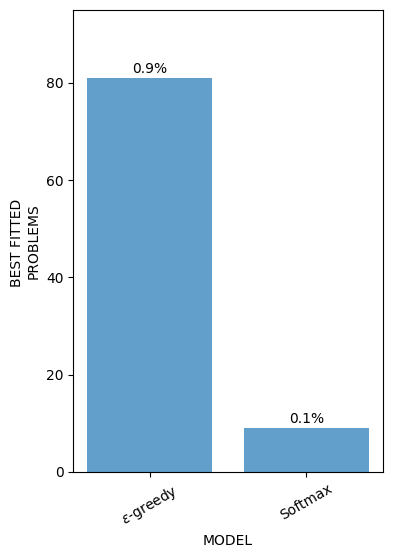

In [47]:
#Make a bar plot
fig, ax = plt.subplots(figsize=(4, 6))
plt.bar(modelNames, values, alpha=0.7)
plt.ylabel("BEST FITTED \nPROBLEMS")
plt.xlabel("MODEL")
plt.ylim(0,95)
plt.xticks(rotation=30)
#Plot the  number of problems above each bar
for i, v in enumerate(values):
    ax.text(i, v + 1, str(np.round(v/90, 2)) +"%", color='black', ha='center')
plt.savefig("modelComparison2.png", bbox_inches='tight', dpi=300)
plt.show()


In [817]:
modelNames = ["$\epsilon$-Betweenness greedy", "$\epsilon$-greedy", "$\epsilon$-Laplacian greedy"]
values = [41,36,13]

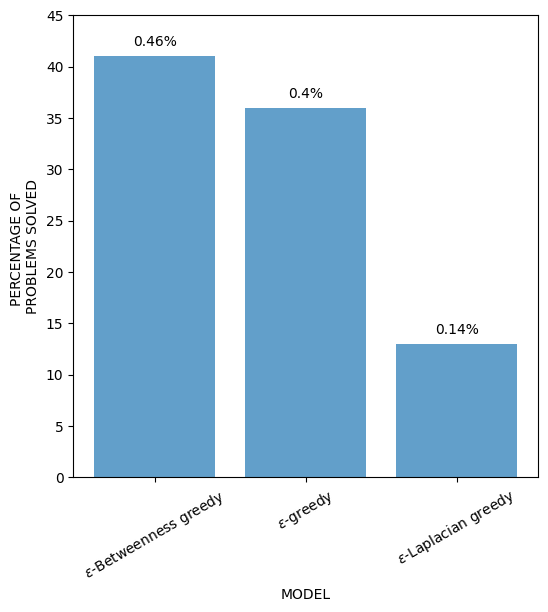

In [820]:
#Make a bar plot
fig, ax = plt.subplots(figsize=(6, 6))
plt.bar(modelNames, values, alpha=0.7)
plt.ylabel("PERCENTAGE OF \nPROBLEMS SOLVED")
plt.xlabel("MODEL")
plt.ylim(0,45)
plt.xticks(rotation=30)
#Plot the  number of problems above each bar
for i, v in enumerate(values):
    ax.text(i, v + 1, str(np.round(v/90, 2)) +"%", color='black', ha='center')
plt.savefig("modelComparisonv2.png", bbox_inches='tight', dpi=300)
plt.show()

## PARAMETRI DEL MODELLO MIGLIORE

In [49]:
def extract_paramters_from_column(column, metric = "Betweenness"):
    """
    Extracts the depth and epsilon parameters from the given column name.
    Parameters:
    column (str): The column name string in the format metric + "_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_negLL"

    Returns:
    tuple: A tuple containing the depth and epsilon as integers and floats respectively.
    """
    pattern = metric + r"_depth_(\d+)_epsilon_([\d\.]+)_negLL"
    match = re.match(pattern, column)
    if match:
        depth = int(match.group(1))
        epsilon = float(match.group(2))
        return depth, epsilon
    else:
        raise ValueError("Column name does not match the expected format.")

In [57]:
dfModel

,problem,minNegLLRandom,minNegLLColumnRandom,minAICRandom,bestModelAICRandom,minBICRandom,bestModelBICRandom,minNegLL_NO_BACKWARD_,minNegLLColumn_NO_BACKWARD_,minAIC_NO_BACKWARD_,...,minBICFORWARD,bestModelBICFORWARD,minAIC,bestModelAIC,bestModelNameAIC,extract_parametersRandom,depthRandom,epsilonRandom,extract_parameters,depthOriginal
0,X5Y51101011110011110111100111110101111100111S2...,31.623204,Random_depth_4_epsilon_0.19_negLL,67.246408,Random_depth_4_epsilon_0.19_AIC,71.532678,Random_depth_4_epsilon_0.19_BIC,112.826702,_NO_BACKWARD__depth_4_epsilon_0.0_BETA_100.0_n...,227.653405,...,134.525811,FORWARD_depth_4_epsilon_0.0_BETA_1.79999999999...,67.246408,minAICRandom,Random,"(4, 0.19)",4,0.19,"(4, 0.0, 100.0)",4
1,X5Y51110110111110010110011111011100110111011S4...,36.815933,Random_depth_4_epsilon_0.18_negLL,77.631866,Random_depth_4_epsilon_0.18_AIC,81.918135,Random_depth_4_epsilon_0.18_BIC,161.180983,_NO_BACKWARD__depth_4_epsilon_0.0_BETA_100.0_n...,324.361966,...,330.648236,FORWARD_depth_4_epsilon_0.0_BETA_0.28_BIC,77.631866,minAICRandom,Random,"(4, 0.18)",4,0.18,"(4, 0.0, 100.0)",4
2,X5Y51111110111111111111111001111011101111101S1...,28.592304,Random_depth_3_epsilon_0.12_negLL,61.184608,Random_depth_3_epsilon_0.12_AIC,65.470878,Random_depth_3_epsilon_0.12_BIC,96.708600,_NO_BACKWARD__depth_3_epsilon_0.0_BETA_100.0_n...,195.417199,...,128.821895,FORWARD_depth_3_epsilon_0.0_BETA_3.19999999999...,61.184608,minAICRandom,Random,"(3, 0.12)",3,0.12,"(3, 0.0, 100.0)",3
3,X5Y50111111111011111010111111001010111111011S7...,93.600000,Random_depth_5_epsilon_0.19_negLL,191.200000,Random_depth_5_epsilon_0.19_AIC,195.486269,Random_depth_5_epsilon_0.19_BIC,177.299086,_NO_BACKWARD__depth_5_epsilon_0.0_BETA_100.0_n...,356.598172,...,362.884441,FORWARD_depth_5_epsilon_0.0_BETA_0.28_BIC,191.200000,minAICRandom,Random,"(5, 0.19)",5,0.19,"(5, 0.0, 100.0)",5
4,X5Y51111111101001111110101100110011110011111S8...,125.569227,Random_depth_1_epsilon_0.15_negLL,255.138454,Random_depth_1_epsilon_0.15_AIC,259.424723,Random_depth_1_epsilon_0.15_BIC,400.844630,_NO_BACKWARD__depth_2_epsilon_0.0_BETA_100.0_n...,803.689261,...,305.381712,FORWARD_depth_1_epsilon_0.0_BETA_1.59999999999...,255.138454,minAICRandom,Random,"(1, 0.15)",1,0.15,"(2, 0.0, 100.0)",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,X6Y8100111101100111111111001111001111111111111...,128.892929,Random_depth_2_epsilon_0.19_negLL,261.785857,Random_depth_2_epsilon_0.19_AIC,266.072126,Random_depth_2_epsilon_0.19_BIC,465.067678,_NO_BACKWARD__depth_1_epsilon_0.0_BETA_100.0_n...,932.135355,...,552.538888,FORWARD_depth_1_epsilon_0.0_BETA_1.4_BIC,261.785857,minAICRandom,Random,"(2, 0.19)",2,0.19,"(1, 0.0, 100.0)",1
86,X6Y8111110111110110111110101100101111111110101...,152.126134,Random_depth_4_epsilon_0.19_negLL,308.252268,Random_depth_4_epsilon_0.19_AIC,312.538538,Random_depth_4_epsilon_0.19_BIC,695.084774,_NO_BACKWARD__depth_7_epsilon_0.0_BETA_100.0_n...,1392.169548,...,429.603943,FORWARD_depth_1_epsilon_0.0_BETA_0.7_BIC,308.252268,minAICRandom,Random,"(4, 0.19)",4,0.19,"(7, 0.0, 100.0)",7
87,X6Y8101111111110100110111100111111100001111111...,212.649652,Random_depth_2_epsilon_0.14_negLL,429.299305,Random_depth_2_epsilon_0.14_AIC,433.585574,Random_depth_2_epsilon_0.14_BIC,628.605785,_NO_BACKWARD__depth_8_epsilon_0.0_BETA_100.0_n...,1259.211569,...,546.349179,FORWARD_depth_1_epsilon_0.0_BETA_0.4_BIC,429.299305,minAICRandom,Random,"(2, 0.14)",2,0.14,"(8, 0.0, 100.0)",8
88,X6Y8110101110011111111110111110010110111001110...,204.106816,Random_depth_1_epsilon_0.19_negLL,412.213632,Random_depth_1_epsilon_0.19_AIC,416.499901,Random_depth_1_epsilon_0.19_BIC,854.259124,_NO_BACKWARD__depth_3_epsilon_0.0_BETA_100.0_n...,1710.518247,...,905.872746,FORWARD_depth_1_epsilon_0.0_BETA_0.28_BIC,412.213632,minAICRandom,Random,"(1, 0.19)",1,0.19,"(3, 0.0, 100.0)",3


In [50]:
dfModel.loc[:, "extract_parametersRandom"] = dfModel["minNegLLColumnRandom"].apply(lambda x: extract_paramters_from_column(x, "Random"))

In [51]:
#Extract the depth and epsilon parameters from the column extract_parameters
dfModel.loc[:, "depthRandom"] = dfModel["extract_parametersRandom"].apply(lambda x: x[0])
dfModel.loc[:, "epsilonRandom"] = dfModel["extract_parametersRandom"].apply(lambda x: x[1])

In [52]:
def extract_OriginalDepth(column, metric = "Betweenness"):
    """
    Extracts the depth and epsilon parameters from the given column name.
    Parameters:
    _NO_BACKWARD__depth_4_epsilon_0.0_BETA_100.0_AIC
    column (str): The column name string in the format metric + "_depth_" + str(depth) + "_epsilon_" +str(epsilon) + "_BETA_" + str(BETA) + "_AIC"
    Returns:
    tuple: A tuple containing the depth and epsilon as integers and floats respectively.
    """
    pattern = metric + r"_depth_(\d+)_epsilon_([\d\.]+)_BETA_([\d\.]+)_AIC"
    match = re.match(pattern, column)
    if match:
        depth = int(match.group(1))
        epsilon = float(match.group(2))
        BETA = float(match.group(3))
        return depth, epsilon, BETA
    else:
        raise ValueError("Column name does not match the expected format.")

In [53]:
#Aplpy extract_OriginalDepth and extract the first value
dfModel.loc[:, "extract_parameters"] = dfModel["bestModelAIC_NO_BACKWARD_"].apply(lambda x: extract_OriginalDepth(x, "_NO_BACKWARD_"))
dfModel.loc[:, "depthOriginal"] = dfModel["extract_parameters"].apply(lambda x: x[0])
#dfModel.loc[:, "epsilon"] = dfModel["extract_parameters"].apply(lambda x: x[1])
#dfModel.loc[:, "BETA"] = dfModel["extract_parameters"].apply(lambda x: x[2])

KeyError: 'depth'

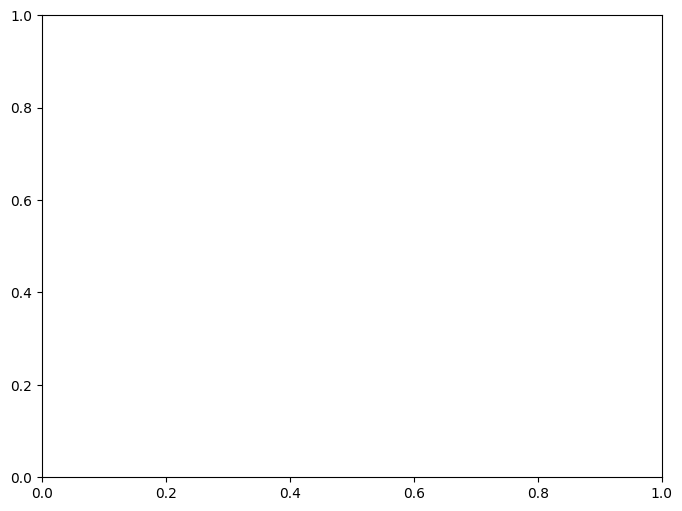

In [54]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create the boxplot
boxprops = dict(facecolor="lightblue", alpha=0.7)  # Define box properties
bp = ax.boxplot(
    [dfModel[dfModel['depth'] == d]['epsilon'] for d in sorted(dfModel['depth'].unique())],
    patch_artist=True,  # Enable box filling
    showfliers=False,
    widths=0.6
)

# Fill the boxes with color
colors = ["lightblue"] * len(bp['boxes'])
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Scatter plot
depths = dfModel["depth"].values
epsilons = dfModel["epsilon"].values
ax.scatter(depths, epsilons, color="darkblue", alpha=0.6)

# Linear regression
m, b = np.polyfit(dfModel["depth"], dfModel["epsilon"], 1)
xtemp = np.array(sorted(dfModel["depth"].unique()))
ax.plot(xtemp, m * xtemp + b, color="royalblue", alpha=0.7)

# Labels and title
ax.set_xlabel("DEPTH", fontsize=12)
ax.set_ylabel("$\epsilon$", fontsize=15)
plt.title("")  # Remove the title
plt.suptitle("")  # Remove the suptitle
#plt.savefig("epsilon_vs_depth.png", bbox_inches='tight', dpi=300)
plt.show()

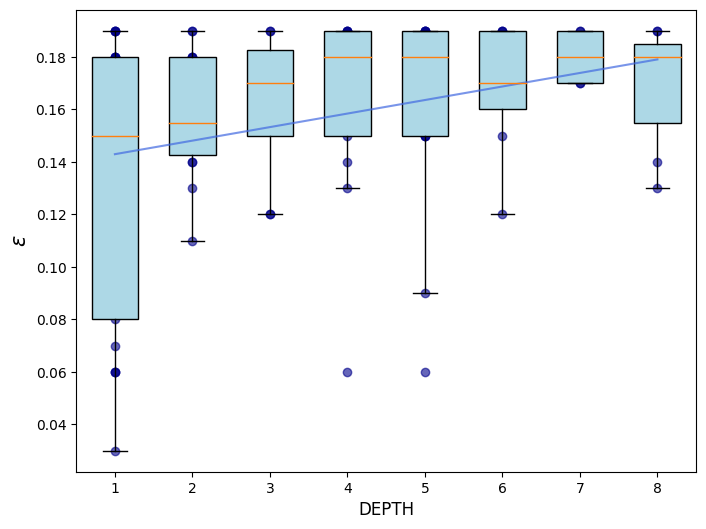

In [56]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create the boxplot
boxprops = dict(facecolor="lightblue", alpha=0.7)  # Define box properties
bp = ax.boxplot(
    [dfModel[dfModel['depthOriginal'] == d]['epsilonRandom'] for d in sorted(dfModel['depthOriginal'].unique())],
    patch_artist=True,  # Enable box filling
    showfliers=False,
    widths=0.6
)

# Fill the boxes with color
colors = ["lightblue"] * len(bp['boxes'])
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Scatter plot
depths = dfModel["depthOriginal"].values
epsilons = dfModel["epsilonRandom"].values
ax.scatter(depths, epsilons, color="darkblue", alpha=0.6)

# Linear regression
m, b = np.polyfit(dfModel["depthOriginal"], dfModel["epsilonRandom"], 1)
xtemp = np.array(sorted(dfModel["depthOriginal"].unique()))
ax.plot(xtemp, m * xtemp + b, color="royalblue", alpha=0.7)

# Labels and title
ax.set_xlabel("DEPTH", fontsize=12)
ax.set_ylabel("$\epsilon$", fontsize=15)
plt.title("")  # Remove the title
plt.suptitle("")  # Remove the suptitle
#plt.savefig("epsilonVsDepthOriginal.png", bbox_inches='tight', dpi=300)
plt.show()

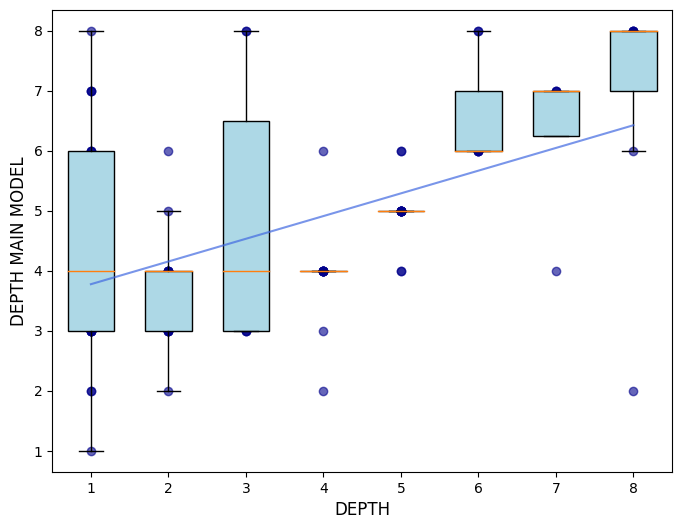

In [803]:
# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Create the boxplot
boxprops = dict(facecolor="lightblue", alpha=0.7)  # Define box properties
bp = ax.boxplot(
    [dfModel[dfModel['depthOriginal'] == d]['depth'] for d in sorted(dfModel['depthOriginal'].unique())],
    patch_artist=True,  # Enable box filling
    showfliers=False,
    widths=0.6
)

# Fill the boxes with color
colors = ["lightblue"] * len(bp['boxes'])
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Scatter plot
depths = dfModel["depthOriginal"].values
epsilons = dfModel["depth"].values
ax.scatter(depths, epsilons, color="darkblue", alpha=0.6)

# Linear regression
m, b = np.polyfit(dfModel["depthOriginal"], dfModel["depth"], 1)
xtemp = np.array(sorted(dfModel["depthOriginal"].unique()))
ax.plot(xtemp, m * xtemp + b, color="royalblue", alpha=0.7)

# Labels and title
ax.set_xlabel("DEPTH", fontsize=12)
ax.set_ylabel("DEPTH MAIN MODEL", fontsize=12)
plt.title("")  # Remove the title
plt.suptitle("")  # Remove the suptitle
plt.savefig("depthVsDepthOriginal.png", bbox_inches='tight', dpi=300)
plt.show()

In [827]:
dfModel

,problem,minNegLLBetweenness,minNegLLColumnBetweenness,minAICBetweenness,bestModelAICBetweenness,minBICBetweenness,bestModelBICBetweenness,minNegLLRandom,minNegLLColumnRandom,minAICRandom,...,bestModel,bestModelName,minAIC,bestModelAIC,bestModelNameAIC,extract_parameters,depth,epsilon,BETA,depthOriginal
0,X5Y51101011110011110111100111110101111100111S2...,31.689977,Betweenness_depth_4_epsilon_0.18_negLL,67.379953,Betweenness_depth_4_epsilon_0.18_AIC,71.666223,Betweenness_depth_4_epsilon_0.18_BIC,31.623204,Random_depth_4_epsilon_0.19_negLL,67.246408,...,minNegLLRandom,Random,67.246408,minAICRandom,Random,"(4, 0.0, 100.0)",4,0.18,100.0,4
1,X5Y51110110111110010110011111011100110111011S4...,36.558476,Betweenness_depth_4_epsilon_0.17_negLL,77.116951,Betweenness_depth_4_epsilon_0.17_AIC,81.403220,Betweenness_depth_4_epsilon_0.17_BIC,36.815933,Random_depth_4_epsilon_0.18_negLL,77.631866,...,minNegLLBetweenness,Betweenness,77.116951,minAICBetweenness,Betweenness,"(4, 0.0, 100.0)",4,0.17,100.0,4
2,X5Y51111110111111111111111001111011101111101S1...,28.560651,Betweenness_depth_3_epsilon_0.05_negLL,61.121301,Betweenness_depth_3_epsilon_0.05_AIC,65.407571,Betweenness_depth_3_epsilon_0.05_BIC,28.592304,Random_depth_3_epsilon_0.12_negLL,61.184608,...,minNegLLBetweenness,Betweenness,61.121301,minAICBetweenness,Betweenness,"(3, 0.0, 100.0)",3,0.05,100.0,3
3,X5Y50111111111011111010111111001010111111011S7...,85.863090,Betweenness_depth_5_epsilon_0.6_negLL,175.726181,Betweenness_depth_5_epsilon_0.6_AIC,180.012450,Betweenness_depth_5_epsilon_0.6_BIC,93.600000,Random_depth_5_epsilon_0.19_negLL,191.200000,...,minNegLLLaplacian,Laplacian,126.380345,minAICLaplacian,Laplacian,"(5, 0.0, 100.0)",5,0.60,100.0,5
4,X5Y51111111101001111110101100110011110011111S8...,87.329139,Betweenness_depth_5_epsilon_0.6_negLL,178.658278,Betweenness_depth_5_epsilon_0.6_AIC,182.944548,Betweenness_depth_5_epsilon_0.6_BIC,125.569227,Random_depth_1_epsilon_0.15_negLL,255.138454,...,minNegLLBetweenness,Betweenness,178.658278,minAICBetweenness,Betweenness,"(2, 0.0, 100.0)",5,0.60,100.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,X6Y8100111101100111111111001111001111111111111...,138.948621,Betweenness_depth_4_epsilon_0.5_negLL,281.897242,Betweenness_depth_4_epsilon_0.5_AIC,286.183512,Betweenness_depth_4_epsilon_0.5_BIC,128.892929,Random_depth_2_epsilon_0.19_negLL,261.785857,...,minNegLLLaplacian,Laplacian,255.936112,minAICLaplacian,Laplacian,"(1, 0.0, 100.0)",4,0.50,100.0,1
86,X6Y8111110111110110111110101100101111111110101...,118.700068,Betweenness_depth_4_epsilon_0.5_negLL,241.400137,Betweenness_depth_4_epsilon_0.5_AIC,245.686406,Betweenness_depth_4_epsilon_0.5_BIC,152.126134,Random_depth_4_epsilon_0.19_negLL,308.252268,...,minNegLLBetweenness,Betweenness,241.400137,minAICBetweenness,Betweenness,"(7, 0.0, 100.0)",4,0.50,100.0,7
87,X6Y8101111111110100110111100111111100001111111...,129.869004,Betweenness_depth_8_epsilon_0.8_negLL,263.738008,Betweenness_depth_8_epsilon_0.8_AIC,268.024278,Betweenness_depth_8_epsilon_0.8_BIC,212.649652,Random_depth_2_epsilon_0.14_negLL,429.299305,...,minNegLLLaplacian,Laplacian,246.900346,minAICLaplacian,Laplacian,"(8, 0.0, 100.0)",8,0.80,100.0,8
88,X6Y8110101110011111111110111110010110111001110...,129.943475,Betweenness_depth_8_epsilon_0.9_negLL,263.886951,Betweenness_depth_8_epsilon_0.9_AIC,268.173220,Betweenness_depth_8_epsilon_0.9_BIC,204.106816,Random_depth_1_epsilon_0.19_negLL,412.213632,...,minNegLLLaplacian,Laplacian,239.262698,minAICLaplacian,Laplacian,"(3, 0.0, 100.0)",8,0.90,100.0,3


In [ ]:
#Import participants data
Rdf = pd.read_csv('./Rdf2.csv')
#Rdf["MinAgentFORWARD"]

In [829]:
#Rename Rdf["TrialID"] to Rdf["problem"]
Rdf = Rdf.rename(columns={"TrialID": "problem"})
#Add Rdf["MinAgentFORWARD"] to dfModel according to the problem column
dfModel = pd.merge(dfModel, Rdf[["problem", "MinAgentFORWARD"]], on="problem")

<Figure size 2000x1500 with 0 Axes>

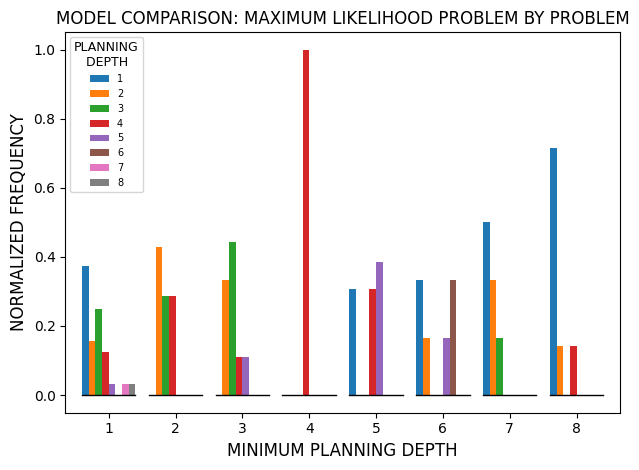

In [838]:
df_grouped = dfModel.groupby("MinAgentFORWARD").depthRandom.value_counts().unstack().fillna(0)

# Normalize the DataFrame by dividing each value by the sum of its row
df_normalized = df_grouped.div(df_grouped.sum(axis=1), axis=0)

plt.figure(figsize=(20, 15))
ax = df_normalized.plot(kind="bar", width=0.8, legend=True)
plt.xticks(rotation=0)
plt.ylabel("NORMALIZED FREQUENCY", fontdict={'fontsize': 12})
plt.xlabel("MINIMUM PLANNING DEPTH", fontdict={'fontsize': 12})
plt.title("MODEL COMPARISON: MAXIMUM LIKELIHOOD PROBLEM BY PROBLEM", fontdict={'fontsize': 12})
plt.tight_layout()

# make the legend smaller and set a title and set the legend outside the plot
plt.legend(title="PLANNING\n   DEPTH", fontsize=7, title_fontsize=9, loc='upper left')
# Add brackets above each x-tick
group_labels = df_normalized.index.tolist()
x_ticks = np.arange(len(group_labels))
bar_width = 0.8
for i, tick in enumerate(x_ticks):
    ax.plot([tick - bar_width / 2, tick + bar_width / 2], [-.001, -.001], color='black', lw=1)
    #ax.text(tick, -.15, group_labels[i], ha='center', va='bottom', fontsize=10)
#Supertitle
plt.show()

<Figure size 2000x1500 with 0 Axes>

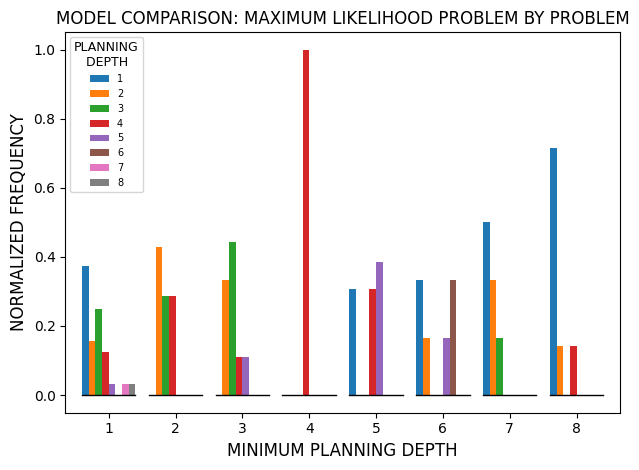

In [ ]:
df_grouped = dfModel.groupby("MinAgentFORWARD").depthRandom.value_counts().unstack().fillna(0)

# Normalize the DataFrame by dividing each value by the sum of its row
df_normalized = df_grouped.div(df_grouped.sum(axis=1), axis=0)

plt.figure(figsize=(20, 15))
ax = df_normalized.plot(kind="bar", width=0.8, legend=True)
plt.xticks(rotation=0)
plt.ylabel("NORMALIZED FREQUENCY", fontdict={'fontsize': 12})
plt.xlabel("MINIMUM PLANNING DEPTH", fontdict={'fontsize': 12})
plt.title("MODEL COMPARISON: MAXIMUM LIKELIHOOD PROBLEM BY PROBLEM", fontdict={'fontsize': 12})
plt.tight_layout()

# make the legend smaller and set a title and set the legend outside the plot
plt.legend(title="PLANNING\n   DEPTH", fontsize=7, title_fontsize=9, loc='upper left')
# Add brackets above each x-tick
group_labels = df_normalized.index.tolist()
x_ticks = np.arange(len(group_labels))
bar_width = 0.8
for i, tick in enumerate(x_ticks):
    ax.plot([tick - bar_width / 2, tick + bar_width / 2], [-.001, -.001], color='black', lw=1)
    #ax.text(tick, -.15, group_labels[i], ha='center', va='bottom', fontsize=10)
#Supertitle
plt.show()

In [849]:
##Test
dfRandom = dfConcat

In [853]:
dfConcat.columns

Index(['problem', 'Random_depth_1_epsilon_0.01_negLL',
       'Random_depth_1_epsilon_0.01_AIC', 'Random_depth_1_epsilon_0.01_BIC',
       'Random_depth_1_epsilon_0.02_negLL', 'Random_depth_1_epsilon_0.02_AIC',
       'Random_depth_1_epsilon_0.02_BIC', 'Random_depth_1_epsilon_0.03_negLL',
       'Random_depth_1_epsilon_0.03_AIC', 'Random_depth_1_epsilon_0.03_BIC',
       ...
       'Random_depth_8_epsilon_0.18_BIC', 'Random_depth_8_epsilon_0.19_negLL',
       'Random_depth_8_epsilon_0.19_AIC', 'Random_depth_8_epsilon_0.19_BIC',
       'minNegLLRandom', 'minNegLLColumnRandom', 'minAICRandom',
       'bestModelAICRandom', 'minBICRandom', 'bestModelBICRandom'],
      dtype='object', length=439)

In [ ]:
#For each row and for each depth, find the model that has the minimum negative loglikelihood
for i, row in dfRandom.iterrows():
    for depth in range(1, 9):
        minAIC = np.inf
        

dfRandom

,problem,Random_depth_1_epsilon_0.01_negLL,Random_depth_1_epsilon_0.01_AIC,Random_depth_1_epsilon_0.01_BIC,Random_depth_1_epsilon_0.02_negLL,Random_depth_1_epsilon_0.02_AIC,Random_depth_1_epsilon_0.02_BIC,Random_depth_1_epsilon_0.03_negLL,Random_depth_1_epsilon_0.03_AIC,Random_depth_1_epsilon_0.03_BIC,...,Random_depth_8_epsilon_0.18_BIC,Random_depth_8_epsilon_0.19_negLL,Random_depth_8_epsilon_0.19_AIC,Random_depth_8_epsilon_0.19_BIC,minNegLLRandom,minNegLLColumnRandom,minAICRandom,bestModelAICRandom,minBICRandom,bestModelBICRandom
0,X5Y51101011110011110111100111110101111100111S2...,113.262103,230.524207,234.810476,104.702856,213.405712,217.691981,86.716803,177.433606,181.719875,...,170.748631,81.230069,166.460137,170.746407,31.623204,Random_depth_4_epsilon_0.19_negLL,67.246408,Random_depth_4_epsilon_0.19,71.532678,Random_depth_4_epsilon_0.19_BIC
1,X5Y51110110111110010110011111011100110111011S4...,376.274033,756.548066,760.834336,354.385872,712.771744,717.058013,297.083707,598.167414,602.453684,...,81.918135,41.131903,86.263806,90.550076,36.815933,Random_depth_4_epsilon_0.18_negLL,86.263806,Random_depth_4_epsilon_0.19,81.918135,Random_depth_4_epsilon_0.18_BIC
2,X5Y51111110111111111111111001111011101111101S1...,356.682648,717.365295,721.651564,376.621342,757.242684,761.528953,289.541538,583.083077,587.369346,...,140.972662,66.603686,137.207372,141.493642,28.592304,Random_depth_3_epsilon_0.12_negLL,71.115569,Random_depth_3_epsilon_0.19,65.470878,Random_depth_3_epsilon_0.12_BIC
3,X5Y50111111111011111010111111001010111111011S7...,173.513869,351.027738,355.314007,164.847326,333.694652,337.980922,170.339809,344.679618,348.965888,...,196.495337,93.600000,191.200000,195.486269,93.600000,Random_depth_5_epsilon_0.19_negLL,191.200000,Random_depth_5_epsilon_0.19,195.486269,Random_depth_5_epsilon_0.19_BIC
4,X5Y51111111101001111110101100110011110011111S8...,191.984382,387.968764,392.255033,183.351481,370.702961,374.989231,157.212447,318.424893,322.711163,...,324.678244,166.383945,336.767890,341.054160,125.569227,Random_depth_1_epsilon_0.15_negLL,258.340213,Random_depth_1_epsilon_0.19,259.424723,Random_depth_1_epsilon_0.15_BIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,X6Y8100111101100111111111001111001111111111111...,206.092318,416.184636,420.470906,178.300528,360.601057,364.887326,170.748260,345.496519,349.782789,...,822.374781,455.223261,914.446523,918.732792,128.892929,Random_depth_2_epsilon_0.19_negLL,261.785857,Random_depth_2_epsilon_0.19,266.072126,Random_depth_2_epsilon_0.19_BIC
86,X6Y8111110111110110111110101100101111111110101...,311.836489,627.672978,631.959248,282.295849,568.591698,572.877968,271.013081,546.026162,550.312432,...,1126.875676,557.435713,1118.871427,1123.157696,152.126134,Random_depth_4_epsilon_0.19_negLL,308.252268,Random_depth_4_epsilon_0.19,312.538538,Random_depth_4_epsilon_0.19_BIC
87,X6Y8101111111110100110111100111111100001111111...,608.632224,1221.264448,1225.550718,372.752336,749.504672,753.790942,598.151948,1200.303897,1204.590166,...,760.478494,472.674194,949.348387,953.634657,212.649652,Random_depth_2_epsilon_0.14_negLL,486.926957,Random_depth_1_epsilon_0.19,433.585574,Random_depth_2_epsilon_0.14_BIC
88,X6Y8110101110011111111110111110010110111001110...,415.515748,835.031495,839.317765,404.276967,812.553934,816.840203,324.920045,653.840090,658.126360,...,787.105524,585.871883,1175.743767,1180.030036,204.106816,Random_depth_1_epsilon_0.19_negLL,412.213632,Random_depth_1_epsilon_0.19,416.499901,Random_depth_1_epsilon_0.19_BIC


['minNegLLRandom', 'minNegLLColumnRandom', 'minAICRandom', 'bestModelAICRandom', 'minBICRandom', 'bestModelBICRandom', 'extract_parametersRandom', 'depthRandom', 'epsilonRandom']


In [ ]:
columnsTBRankedLs = []
for TrialID in dfModel.TrialID.unique():
    #bestModel = Rdf.loc[Rdf.TrialID == TrialID, "BestModelType"].values[0]
    bestModel = ""
    bestBeta = dfModel.loc[dfModel.TrialID == TrialID, "BestBeta"].values[0]
    columnsTBRankedLs.append(["PD" +bestModel +str(depth) + "Epsilon" +str(epsilon) + "BETA" + str(bestBeta) + "ITMAX" + str(IT_MAX) for depth in range(1, 9)])
averageRanks = np.zeros((len(dfModel.TrialID.unique()), 9))
for trialIndex, TrialID in enumerate(Rdf.TrialID.unique()):
    for columnNameLs in columnsTBRankedLs:
        #Get the loglikelihoods of columnNameLs
        logLikelihoods = dfModel.loc[dfModel.TrialID == TrialID, [columnName for columnName in columnNamesLLFORWARD]].values[0]
        #Add small noise to avoid ties
        #logLikelihoods += np.random.normal(0, 10**-10, len(logLikelihoods))
        depthRanked = np.argsort(-logLikelihoods) + 1
        for depth in range(1, 9):
            averageRanks[trialIndex, depth-1] = np.where(depthRanked == depth)[0][0]
        averageRanks[trialIndex, -1] = np.where(depthRanked ==  Rdf.loc[Rdf.TrialID == TrialID, "MinAgentFORWARD"].values[0])[0][0]

# PARTE 2

In [396]:
dfParticipants = pd.read_csv('./Rdf2.csv')

In [4]:
# Rename columns in dfParticipants
dfParticipants.rename(columns={col: f"FORWARD{col[10]}" for col in dfParticipants.columns if col.startswith("PD_FORWARD") and col.endswith("Epsilon0.0BETA100.0ITMAX500LL")}, inplace=True)
#Do the same for the BACKWARD columns
dfParticipants.rename(columns={col: f"BACKWARD{col[11]}" for col in dfParticipants.columns if col.startswith("PD_BACKWARD") and col.endswith("Epsilon0.0BETA100.0ITMAX500LL")}, inplace=True)

In [15]:
dfOldModels = dfParticipants[["TrialID", 'MinAgentFORWARD', 'BestDepthBACKWARD',
       'BACKWARD1', 'BACKWARD2', 'BACKWARD3', 'BACKWARD4', 'BACKWARD5',
       'BACKWARD6', 'BACKWARD7', 'BACKWARD8','BestDepthFORWARD', 'FORWARD1',
       'FORWARD2', 'FORWARD3', 'FORWARD4', 'FORWARD5', 'FORWARD6', 'FORWARD7',
       'FORWARD8']]

In [16]:
#Iterate over the rows of the dataframe
TRIAL_ID = []
FORWARD_LL = []
BACKWARD_LL = []
MIN_DEPTH = []
for mapName in dfOldModels["TrialID"].values:
    TRIAL_ID.append(mapName)
    BestDepthBACKWARD = dfOldModels[dfOldModels["TrialID"] == mapName]["BestDepthBACKWARD"].values[0]
    BestDepthFORWARD = dfOldModels[dfOldModels["TrialID"] == mapName]["BestDepthFORWARD"].values[0]
    FORWARD_LL.append(-dfOldModels[dfOldModels["TrialID"] == mapName]["FORWARD" + str(BestDepthFORWARD)].values[0])
    BACKWARD_LL.append(-dfOldModels[dfOldModels["TrialID"] == mapName]["BACKWARD" + str(BestDepthBACKWARD)].values[0])
    MIN_DEPTH.append( dfOldModels[dfOldModels["TrialID"] == mapName]["MinAgentFORWARD"].values[0])
#Create a new dataframe with the results
dfOldModelsResults = pd.DataFrame({"TrialID": TRIAL_ID, "MIN_DEPTH": MIN_DEPTH,  "FORWARD_negLL": FORWARD_LL, "BACKWARD_negLL": BACKWARD_LL})
#Rename TrialID to Map in dfOldModelsResults
dfOldModelsResults.rename(columns={"TrialID": "Map"}, inplace=True)

In [17]:
dfNewModels = pd.read_csv("./bfs_merged_results_.csv")

In [18]:
# Group by 'Map' and find the row with the minimum 'NegLogLikelihood' for each group
min_negloglikelihood_df = dfNewModels.loc[dfNewModels.groupby('Map')['NegLogLikelihood'].idxmin()]

# Create a new dataframe with the required information
result_df = min_negloglikelihood_df[['Map', 'MaxDepth', 'NegLogLikelihood']].reset_index(drop=True)

# Display the new dataframe
result_df

,Map,MaxDepth,NegLogLikelihood
0,X5Y50011011111111101111011011111111111111011S2...,22,171.315228
1,X5Y50011111010011110111111101011111111111111S1...,12,55.521943
2,X5Y50111011111011011111111111010110111111100S1...,27,83.897131
3,X5Y50111111111011111010111111001010111111011S7...,19,144.143905
4,X5Y50111111111111101011101101111111111111111S7...,29,35.503067
...,...,...,...
85,X6Y8111111011110111100101001101110110110110000...,13,159.298664
86,X6Y8111111011111011111011101111100110110110000...,7,177.406187
87,X6Y8111111111000101100110011111101010101011111...,22,177.328675
88,X6Y8111111111101111110011101001111110110100111...,14,164.653809


In [19]:
#To each value of Map in result_df remove ".json"
result_df["Map"] = result_df["Map"].apply(lambda x: x.replace(".json", ""))

In [20]:
# dfOldModelsResults and result_df along the column "Map"
dfMerged = pd.merge(dfOldModelsResults, result_df, on="Map")

In [21]:
dfMerged

,Map,MIN_DEPTH,FORWARD_negLL,BACKWARD_negLL,MaxDepth,NegLogLikelihood
0,X5Y50011011111111101111011011111111111111011S2...,1,407.755541,406.317272,22,171.315228
1,X5Y50011111010011110111111101011111111111111S1...,1,115.129255,115.129255,12,55.521943
2,X5Y50111011111011011111111111010110111111100S1...,1,368.413615,368.413615,27,83.897131
3,X5Y50111111111011111010111111001010111111011S7...,1,253.284360,253.284360,19,144.143905
4,X5Y50111111111111101011101101111111111111111S7...,1,69.077553,69.077553,29,35.503067
...,...,...,...,...,...,...
85,X6Y8111111011110111100101001101110110110110000...,8,736.827230,736.827230,13,159.298664
86,X6Y8111111011111011111011101111100110110110000...,1,550.064722,510.866167,7,177.406187
87,X6Y8111111111000101100110011111101010101011111...,4,805.904783,805.904783,22,177.328675
88,X6Y8111111111101111110011101001111110110100111...,3,528.481877,529.212228,14,164.653809


In [22]:
dfDFS = pd.read_csv('./dfs_results.csv')
#Drop the column "Unnamed: 0"
dfDFS.drop(columns=["Unnamed: 0"], inplace=True)
#Swap the names of the columns "Distribution" and "NegLogLikelihood"
dfDFS.rename(columns={"Distribution": "NegLogLikelihood", "NegLogLikelihood": "Distribution"}, inplace=True)

In [23]:
# Group by 'Map' and find the row with the minimum 'NegLogLikelihood' for each group
min_negloglikelihood_df_dfs = dfDFS.loc[dfDFS.groupby('Map')['NegLogLikelihood'].idxmin()]


In [24]:
min_negloglikelihood_df_dfs["Map"] = min_negloglikelihood_df_dfs["Map"].apply(lambda x: x.replace(".json", ""))

In [25]:
# Create a new dataframe with the required information
result_df_dfs = min_negloglikelihood_df_dfs[['Map', 'MaxDepth', 'NegLogLikelihood']].reset_index(drop=True)

In [26]:
#Merge the dataframes
dfMergedFinal = pd.merge(dfMerged, result_df_dfs, on="Map")

In [27]:
dfMergedFinal

,Map,MIN_DEPTH,FORWARD_negLL,BACKWARD_negLL,MaxDepth_x,NegLogLikelihood_x,MaxDepth_y,NegLogLikelihood_y
0,X5Y50011011111111101111011011111111111111011S2...,1,407.755541,406.317272,22,171.315228,11,125.804311
1,X5Y50011111010011110111111101011111111111111S1...,1,115.129255,115.129255,12,55.521943,10,62.568327
2,X5Y50111011111011011111111111010110111111100S1...,1,368.413615,368.413615,27,83.897131,6,129.165085
3,X5Y50111111111011111010111111001010111111011S7...,1,253.284360,253.284360,19,144.143905,7,241.635301
4,X5Y50111111111111101011101101111111111111111S7...,1,69.077553,69.077553,29,35.503067,21,65.765103
...,...,...,...,...,...,...,...,...
85,X6Y8111111011110111100101001101110110110110000...,8,736.827230,736.827230,13,159.298664,10,168.763691
86,X6Y8111111011111011111011101111100110110110000...,1,550.064722,510.866167,7,177.406187,2,246.998478
87,X6Y8111111111000101100110011111101010101011111...,4,805.904783,805.904783,22,177.328675,15,218.568411
88,X6Y8111111111101111110011101001111110110100111...,3,528.481877,529.212228,14,164.653809,10,176.102930


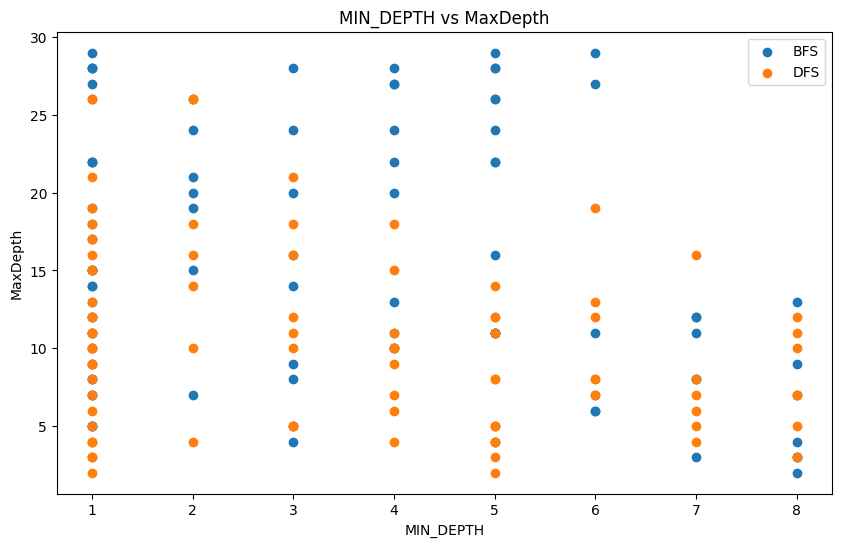

In [31]:
## Plot MIN_DEPTH vs MaxDepth_x and MaxDepth_y
plt.figure(figsize=(10, 6))
plt.scatter(dfMergedFinal["MIN_DEPTH"], dfMergedFinal["MaxDepth_x"], label="BFS")
plt.scatter(dfMergedFinal["MIN_DEPTH"], dfMergedFinal["MaxDepth_y"], label="DFS")
plt.xlabel("MIN_DEPTH")
plt.ylabel("MaxDepth")
plt.legend()
plt.title("MIN_DEPTH vs MaxDepth")
plt.show()
